# **CIFAR 10**
A FFNN (Fully Forward Neural Network) and CNN (Convolutional Nerual Network) have been modeled

## Import required packages

In [1]:
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import matplotlib.pyplot as plt 


## Defining our Transforms


In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


## Gathering the train and test data

In [3]:
train_data=datasets.CIFAR10('data',train=True,download=True,transform=transform_train)
test_data=datasets.CIFAR10('data',train=False,download=True,transform=transform_test)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## Defining our Train, Valid and Test Dataloaders

In [4]:
num_workers=0
batch_size=50
valid_size=0.2
train_length = len(train_data)
indices=list(range(len(train_data)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]

train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

train_loader=DataLoader(train_data,num_workers=num_workers,batch_size=batch_size,sampler=train_sampler)
valid_loader=DataLoader(train_data,num_workers=num_workers,batch_size=batch_size,sampler=validation_sampler)
test_loader=DataLoader(test_data,shuffle=True,num_workers=num_workers,batch_size=batch_size)

In [5]:
dataiter=iter(train_loader)
images,labels=dataiter.next()
images,labels,images.shape,labels.shape

(tensor([[[[-1.0000, -1.0000, -0.6863,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -0.6941,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -0.6941,  ..., -0.4039, -0.3490, -0.3412],
           ...,
           [-0.7647, -0.7412, -0.6784,  ..., -0.4510, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -0.4824, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -0.4902, -1.0000, -1.0000]],
 
          [[-1.0000, -1.0000, -0.0275,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -0.0196,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -0.0353,  ...,  0.0824,  0.0902,  0.1059],
           ...,
           [-0.2706, -0.2627, -0.2784,  ..., -0.2000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -0.2157, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -0.2157, -1.0000, -1.0000]],
 
          [[-1.0000, -1.0000,  0.1843,  ..., -1.0000, -1.0000, -1.0000],
           [-

## Visualizing a Training batch

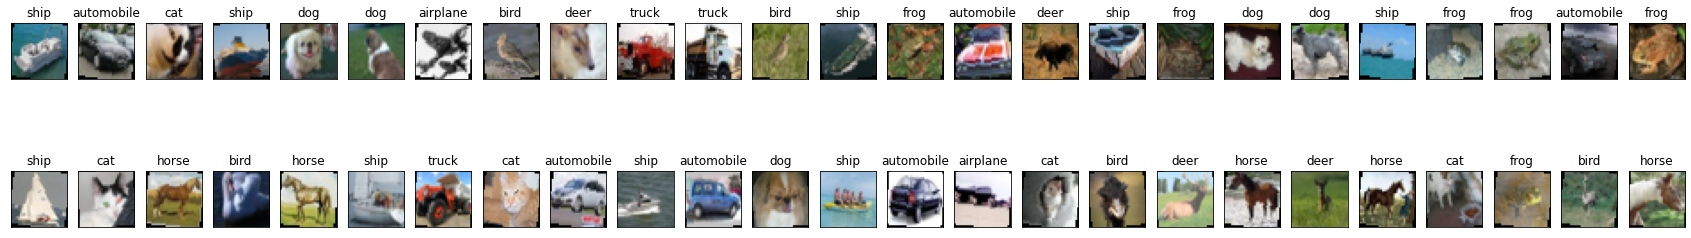

In [6]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def RGBshow(img):
    img=img*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

fig=plt.figure(1,figsize=(30,5))
for idx in range(batch_size):
    ax=fig.add_subplot(2,batch_size/2,idx+1,xticks=[],yticks=[])
    RGBshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Defining our Neural Net Architecture

In [7]:
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.fc1=nn.Linear(3*32*32,2048)
        self.fc2=nn.Linear(2048,1024)
        self.fc3=nn.Linear(1024,512)
        self.fc4=nn.Linear(512,256)
        self.out=nn.Linear(256,10)
        self.dropout=nn.Dropout(0.25)

    def forward(self,x):
        x=x.view(-1,32*32*3)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.dropout(F.relu(self.fc3(x)))
        x=self.dropout(F.relu(self.fc4(x)))
        x=self.out(x)
        return x

class convNet(nn.Module):
    def __init__(self):
        super(convNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.conv4=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)  

        self.dropout=nn.Dropout(0.25)
        self.fc1=nn.Linear(128*2*2,256)
        self.fc2=nn.Linear(256,64)
        self.out=nn.Linear(64,10)


    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        x=self.pool(F.relu(self.conv4(x)))
        x=x.view(-1,128*2*2)
        x = self.dropout(x)
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.out(x)   
        return x



In [8]:
def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

model_1=FNet()
model_2=convNet()
model_1.apply(weight_init_normal),model_2.apply(weight_init_normal)
use_cuda=True
if use_cuda and torch.cuda.is_available():
    model_1.cuda()
    model_2.cuda()
print(model_1,'\n\n\n\n',model_2,'\n','On GPU : ',use_cuda and torch.cuda.is_available())

FNet(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
) 



 convNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)


## Defining our Loss Function

In [9]:
criterion=nn.CrossEntropyLoss()

## Training and Validation Phase

In [10]:
def trainNet(model,lr,trainer,validater):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)


    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    epochs=50

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf 

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,labels in trainer:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,labels in validater:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            output=model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(trainer)
        valid_loss = valid_loss/len(validater)


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z=type(model).__name__
            torch.save(model.state_dict(), z+'_model.pth')
            valid_loss_min=valid_loss
    return(loss_keeper)

In [11]:
m1_loss=trainNet(model_1,0.001,train_loader,valid_loader)



Epoch : 1	Training Loss : 1.8914843225479125	Validation Loss : 1.7861855268478393
Validation loss decreased from : inf ----> 1.7861855268478393 ----> Saving Model.......

Epoch : 2	Training Loss : 1.7354288077354432	Validation Loss : 1.6551058852672578
Validation loss decreased from : 1.7861855268478393 ----> 1.6551058852672578 ----> Saving Model.......

Epoch : 3	Training Loss : 1.6762275910377502	Validation Loss : 1.5982872515916824
Validation loss decreased from : 1.6551058852672578 ----> 1.5982872515916824 ----> Saving Model.......

Epoch : 4	Training Loss : 1.6390963144600392	Validation Loss : 1.569320039153099
Validation loss decreased from : 1.5982872515916824 ----> 1.569320039153099 ----> Saving Model.......

Epoch : 5	Training Loss : 1.6149707373976707	Validation Loss : 1.5382473665475844
Validation loss decreased from : 1.569320039153099 ----> 1.5382473665475844 ----> Saving Model.......

Epoch : 6	Training Loss : 1.5909801548719407	Validation Loss : 1.5273622739315034
Valid

In [12]:
m1_loss


{'train': [1.8914843225479125,
  1.7354288077354432,
  1.6762275910377502,
  1.6390963144600392,
  1.6149707373976707,
  1.5909801548719407,
  1.5719573403894902,
  1.5664258900284767,
  1.5479162077605724,
  1.5298011289536952,
  1.5173952253162861,
  1.5045500868558883,
  1.4998823773860932,
  1.4900255347788334,
  1.4883685764670371,
  1.4720067113637925,
  1.4649032546579839,
  1.45382926620543,
  1.4481224296987056,
  1.443694968894124,
  1.4364663189649582,
  1.4286708252131939,
  1.4269703105092049,
  1.4123086772859097,
  1.4123282507807016,
  1.4244192230701447,
  1.4051923021674155,
  1.3934523110091686,
  1.3902008696645498,
  1.3938843380659818,
  1.3826227422058581,
  1.3815101287513971,
  1.374132251739502,
  1.3610564179718494,
  1.36209069930017,
  1.3622202119231224,
  1.3631627985835075,
  1.3622260969877242,
  1.3544758398085832,
  1.3410094776004553,
  1.337626836448908,
  1.3394730857014656,
  1.322536734715104,
  1.3242478519678116,
  1.3359934682399035,
  1.33749

In [13]:
m2_loss=trainNet(model_2,0.001,train_loader,valid_loader)


Epoch : 1	Training Loss : 1.716832646280527	Validation Loss : 1.372470233440399
Validation loss decreased from : inf ----> 1.372470233440399 ----> Saving Model.......

Epoch : 2	Training Loss : 1.338187035098672	Validation Loss : 1.1747579601407052
Validation loss decreased from : 1.372470233440399 ----> 1.1747579601407052 ----> Saving Model.......

Epoch : 3	Training Loss : 1.1763792869448662	Validation Loss : 1.0562058836221695
Validation loss decreased from : 1.1747579601407052 ----> 1.0562058836221695 ----> Saving Model.......

Epoch : 4	Training Loss : 1.0854558511078358	Validation Loss : 1.0284024575352668
Validation loss decreased from : 1.0562058836221695 ----> 1.0284024575352668 ----> Saving Model.......

Epoch : 5	Training Loss : 1.0104725854843855	Validation Loss : 0.9176352521777154
Validation loss decreased from : 1.0284024575352668 ----> 0.9176352521777154 ----> Saving Model.......

Epoch : 6	Training Loss : 0.9721706546097993	Validation Loss : 0.9357278496026993

Epoch 

In [14]:
m2_loss


{'train': [1.716832646280527,
  1.338187035098672,
  1.1763792869448662,
  1.0854558511078358,
  1.0104725854843855,
  0.9721706546097993,
  0.9350394625216722,
  0.8908793176710605,
  0.8700262823328376,
  0.849644378721714,
  0.8214490864053369,
  0.8020877300575375,
  0.7864096334949136,
  0.772134379260242,
  0.7597009083256125,
  0.749008767567575,
  0.7426711942255497,
  0.7281675378233194,
  0.7243577725812793,
  0.7076545771956444,
  0.7071526535600424,
  0.7023186306655407,
  0.6896255945786833,
  0.6929806116595865,
  0.6732358633354306,
  0.6808948734775185,
  0.6677980388328433,
  0.6625024812668562,
  0.6534148543328047,
  0.6557108856737613,
  0.641195742227137,
  0.6362130276672542,
  0.6313847859948873,
  0.6336773931607604,
  0.6285666101053358,
  0.622393993139267,
  0.6228110155463219,
  0.6265616923198104,
  0.6128259899094701,
  0.6157739811018109,
  0.6117634375020862,
  0.6048382629826665,
  0.6052186808735133,
  0.5989311215840281,
  0.5986734641715884,
  0.5926

## Loading model from Lowest Validation Loss

In [15]:
# Loading the model from the lowest validation loss 
model_1.load_state_dict(torch.load('FNet_model.pth'))
model_2.load_state_dict(torch.load('convNet_model.pth'))


<All keys matched successfully>

In [16]:
print(model_1.state_dict,'\n\n\n\n',model_2.state_dict)

<bound method Module.state_dict of FNet(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)> 



 <bound method Module.state_dict of convNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, 

## Plotting Training and Validation Losses

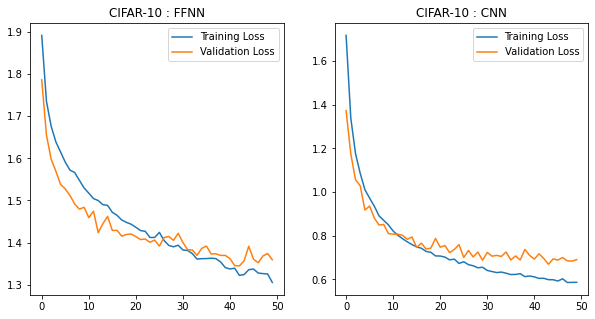

In [17]:
title=['FFNN','CNN']
model_losses=[m1_loss,m2_loss]
fig=plt.figure(1,figsize=(10,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,2,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title('CIFAR-10 : '+title[idx-1])
  idx+=1
  plt.legend();

## Testing Phase

In [18]:
def test(model):
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # test the model with dropout layers off
    for images,labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
        output=model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for idx in range(batch_size):
            label = labels[idx]
            class_correct[label] += correct[idx].item()
            class_total[label] += 1


    test_loss=test_loss/len(test_loader)
    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {classes[i]} : {float(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print(f"\nOverall Test Accuracy : {float(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    # get sample outputs
    if use_cuda and torch.cuda.is_available():
      images,labels=images.cuda(),labels.cuda()
    output = model(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.cpu().numpy()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 15))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(5, batch_size/5, idx+1, xticks=[], yticks=[])
        RGBshow(np.squeeze(images[idx]))
        ax.set_title("{}({}) for {}({})".format(classes[preds[idx]],str(preds[idx].item()), classes[labels[idx]],str(labels[idx].item())),
                    color=("blue" if preds[idx]==labels[idx] else "red"))

## Visualizing a Test batch with results

### FFNN

For FNet :
Test Loss: 1.3889298540353776
Correctly predicted per class : [606.0, 710.0, 339.0, 361.0, 504.0, 368.0, 579.0, 568.0, 717.0, 529.0], Total correctly perdicted : 5281.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class airplane : 60.6% where 606 of 1000 were predicted correctly
Test Accuracy of class automobile : 71.0% where 710 of 1000 were predicted correctly
Test Accuracy of class bird : 33.9% where 339 of 1000 were predicted correctly
Test Accuracy of class cat : 36.1% where 361 of 1000 were predicted correctly
Test Accuracy of class deer : 50.4% where 504 of 1000 were predicted correctly
Test Accuracy of class dog : 36.8% where 368 of 1000 were predicted correctly
Test Accuracy of class frog : 57.9% where 579 of 1000 were predicted correctly
Test Accuracy of class horse : 56.8% where 568 of 1000 were predicted correctly
Test Accuracy of class ship

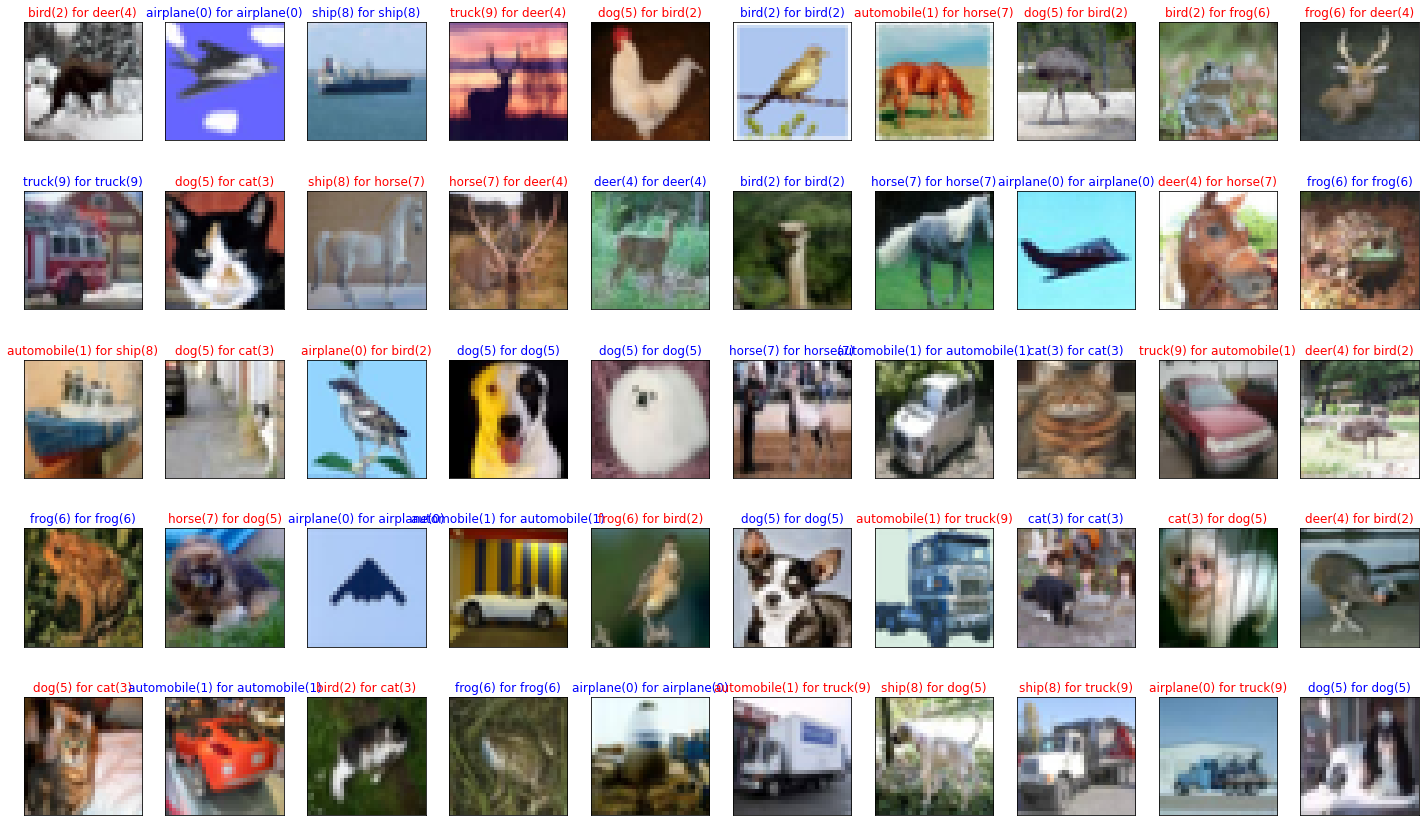

In [19]:
test(model_1)

### CNN

For convNet :
Test Loss: 0.6464765165746212
Correctly predicted per class : [823.0, 892.0, 683.0, 575.0, 769.0, 636.0, 851.0, 853.0, 864.0, 877.0], Total correctly perdicted : 7823.0
Total Predictions per class : [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0], Total predictions to be made : 10000.0

Test Accuracy of class airplane : 82.3% where 823 of 1000 were predicted correctly
Test Accuracy of class automobile : 89.2% where 892 of 1000 were predicted correctly
Test Accuracy of class bird : 68.3% where 683 of 1000 were predicted correctly
Test Accuracy of class cat : 57.5% where 575 of 1000 were predicted correctly
Test Accuracy of class deer : 76.9% where 769 of 1000 were predicted correctly
Test Accuracy of class dog : 63.6% where 636 of 1000 were predicted correctly
Test Accuracy of class frog : 85.1% where 851 of 1000 were predicted correctly
Test Accuracy of class horse : 85.3% where 853 of 1000 were predicted correctly
Test Accuracy of class s

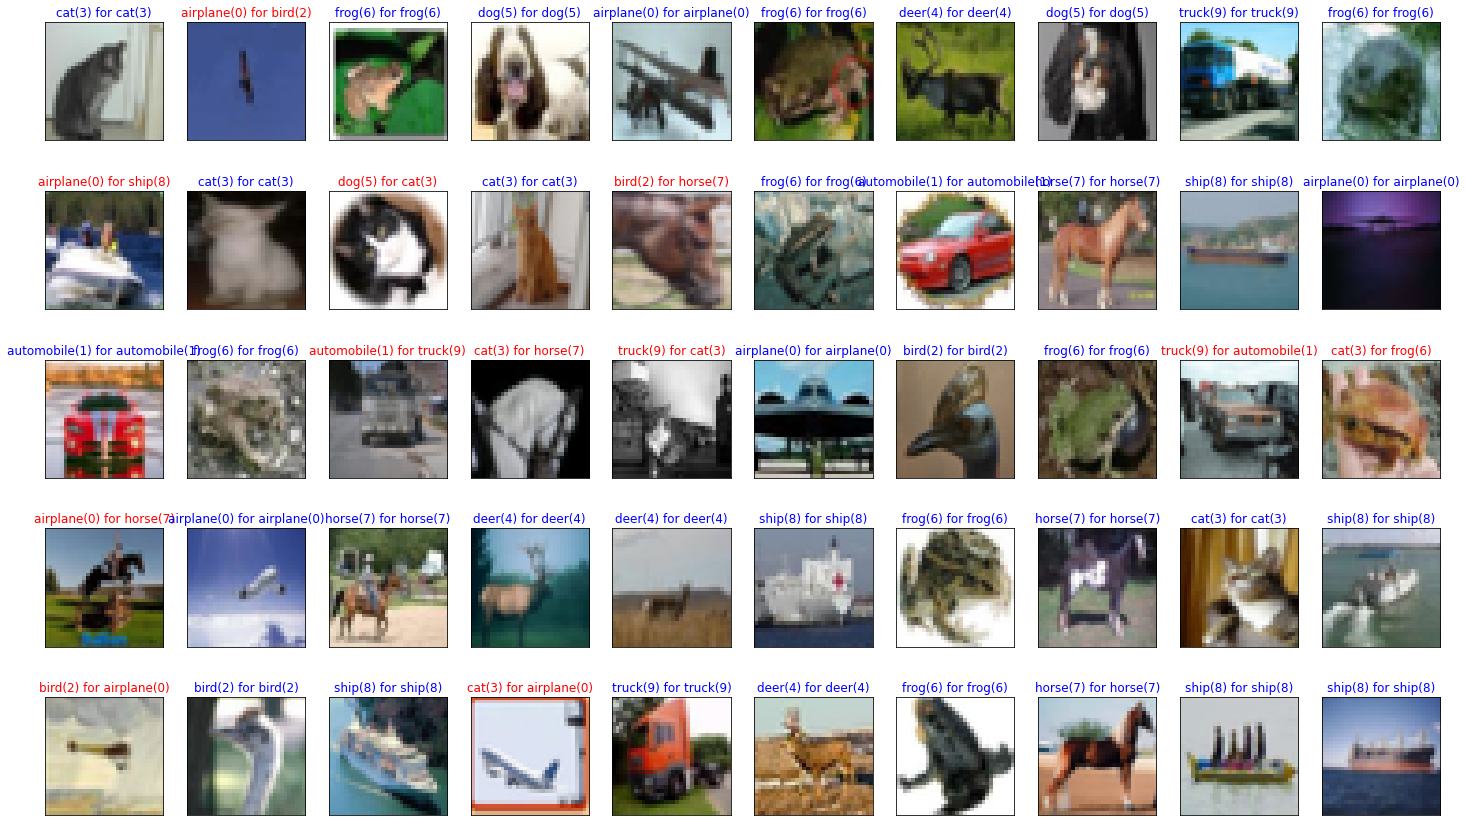

In [20]:
test(model_2)